In [1]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
import os

In [70]:
local_weight_file = './pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

In [71]:
# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [72]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [73]:
# Flatten the output layer to 1 dimension

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.MaxPooling2D()(last_output)
x = layers.Flatten()(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)     
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
rednessModel = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
rednessModel.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_193 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [74]:
# Set the training parameters
rednessModel.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [78]:
base_dir = '../Dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training redness pictures
train_redness_dir = os.path.join(train_dir, 'redness') 

# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal2') 

# Directory with validation redness pictures
validation_redness_dir = os.path.join(validation_dir, 'redness') 

# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal2')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['redness', 'normal2'],
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         classes=['redness', 'normal2'],
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 198 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [79]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and (logs.get('accuracy') > 0.98 or logs.get('accuracy') < 0.5):
            print("\n Cancelling training")
            self.model.stop_training = True

In [80]:
callbacks = myCallback()
history = rednessModel.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            callbacks=[callbacks]
            )

Epoch 1/25
10/10 [==============================] - 6s 660ms/step - loss: 0.9913 - accuracy: 0.5909 - val_loss: 0.7676 - val_accuracy: 0.6562
Epoch 2/25
10/10 [==============================] - 6s 528ms/step - loss: 0.4799 - accuracy: 0.7576 - val_loss: 0.4122 - val_accuracy: 0.7917
Epoch 3/25
10/10 [==============================] - 6s 572ms/step - loss: 0.3488 - accuracy: 0.8384 - val_loss: 0.3171 - val_accuracy: 0.8854
Epoch 4/25
10/10 [==============================] - 6s 570ms/step - loss: 0.2768 - accuracy: 0.8788 - val_loss: 0.2222 - val_accuracy: 0.9375
Epoch 5/25
10/10 [==============================] - 6s 579ms/step - loss: 0.1622 - accuracy: 0.9545 - val_loss: 0.2062 - val_accuracy: 0.9271
Epoch 6/25
10/10 [==============================] - 6s 572ms/step - loss: 0.1527 - accuracy: 0.9495 - val_loss: 0.1676 - val_accuracy: 0.9479
Epoch 7/25
10/10 [==============================] - 6s 564ms/step - loss: 0.1036 - accuracy: 0.9697 - val_loss: 0.2002 - val_accuracy: 0.9271
Epoch 

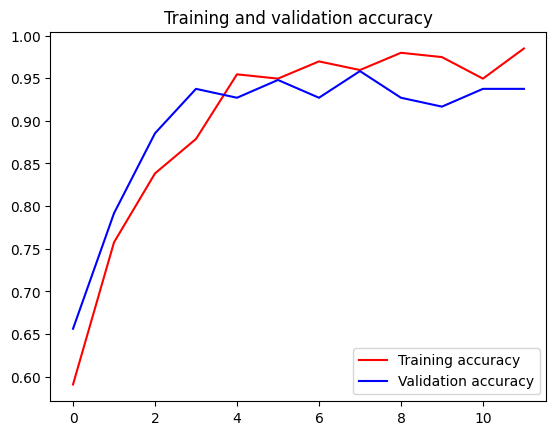

<Figure size 640x480 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

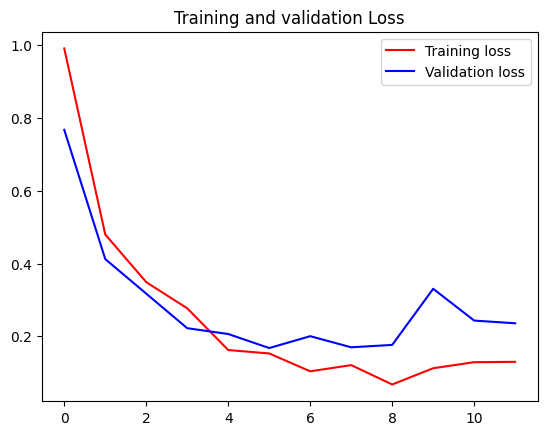

<Figure size 640x480 with 0 Axes>

In [82]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [36]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.utils import load_img, img_to_array

#Code for open dialog window on Local Machine
root = tk.Tk()
root.withdraw()
uploaded = filedialog.askopenfilename()
 
#Predicting images
path = uploaded
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = rednessModel.predict(images, batch_size=10)
print(classes[0])
    
if classes[0]>0.5:
  print("noredness")
else:
  print("redness")
 

1/1 [==============================] - 0s 41ms/step
[0.68120545]
 noredness


----

In [ ]:
import pickle

# Load the previously saved model from a file
with open("acneModel.pkl", "rb") as f:
    acneModel = pickle.load(f)

# Create a dictionary with your models
dump = {
    'model': acneModel,
    'model2': rednessModel,
}

# Save your models to a file using pickle
with open("scanningmodel.pkl", "wb") as f:
    pickle.dump(dump, f)
